# Fitting the Historical SST

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs

In [2]:
# Read in data catalog

df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [3]:
# Find sea surface temperature

df_tos = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'tos' & experiment_id == 'historical' & member_id=='r1i1p1f1'")
df_tos

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
9976,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
9977,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
28719,CMIP,IPSL,IPSL-CM6A-LR,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
32357,CMIP,NASA-GISS,GISS-E2-1-G,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/hi...,NaN,20180827
43345,CMIP,BCC,BCC-CSM2-MR,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historic...,NaN,20181126
43554,CMIP,BCC,BCC-ESM1,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/historical/...,NaN,20181129
44567,CMIP,MIROC,MIROC6,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/historical/...,NaN,20181212
45844,CMIP,AWI,AWI-CM-1-1-MR,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/AWI/AWI-CM-1-1-MR/histor...,NaN,20181218
59298,CMIP,NCAR,CESM2,historical,r1i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
59347,CMIP,NCAR,CESM2,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308


In [4]:
df_ts = df_tos.drop_duplicates('source_id').head(20)
df_ts

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
9976,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
28719,CMIP,IPSL,IPSL-CM6A-LR,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
32357,CMIP,NASA-GISS,GISS-E2-1-G,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/hi...,NaN,20180827
43345,CMIP,BCC,BCC-CSM2-MR,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historic...,NaN,20181126
43554,CMIP,BCC,BCC-ESM1,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/historical/...,NaN,20181129
44567,CMIP,MIROC,MIROC6,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/historical/...,NaN,20181212
45844,CMIP,AWI,AWI-CM-1-1-MR,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/AWI/AWI-CM-1-1-MR/histor...,NaN,20181218
59298,CMIP,NCAR,CESM2,historical,r1i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
68262,CMIP,SNU,SAM0-UNICON,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/SNU/SAM0-UNICON/historic...,NaN,20190323
69870,CMIP,NASA-GISS,GISS-E2-1-H,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-H/hi...,NaN,20190403


In [28]:
# View one dataset - IPSL dataset

gcs = gcsfs.GCSFileSystem(token='anon')

# get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_ts.zstore.values[1]

# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True)
ds

<xarray.Dataset>
Dimensions:         (y: 332, x: 362, nvertex: 4, time: 1980, axis_nbounds: 2)
Coordinates:
    bounds_nav_lat  (y, x, nvertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    bounds_nav_lon  (y, x, nvertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    nav_lat         (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    nav_lon         (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
  * time            (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T...
    time_bounds     (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    area            (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    tos             (time, y, x) float32 dask.array<chunksize=(252, 332, 362), meta=np.ndarray>
Attributes: (12/54)
    CMIP6_CV_version:       cv=6.2.3.5-2-g63b123e
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  historical
    NCO:                    "4.6.0"
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    tracking_id:            hdl:21.14100/01f4d96a-9054-4974-b8dd-4f91e73989d2
    variable_id:            tos
    variant_label:          r1i1p1f1
    status:                 2019-11-10;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/01f4d96a-9054-4974-b8dd-4f91e73989d2
    version_id:             v20180803

In [35]:
# IPSL dataset causing problems - skip for now
df_ts = df_ts.drop(index=28719)
df_ts

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
9976,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
32357,CMIP,NASA-GISS,GISS-E2-1-G,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/hi...,NaN,20180827
43345,CMIP,BCC,BCC-CSM2-MR,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historic...,NaN,20181126
43554,CMIP,BCC,BCC-ESM1,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/historical/...,NaN,20181129
44567,CMIP,MIROC,MIROC6,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/historical/...,NaN,20181212
45844,CMIP,AWI,AWI-CM-1-1-MR,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/AWI/AWI-CM-1-1-MR/histor...,NaN,20181218
59298,CMIP,NCAR,CESM2,historical,r1i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
68262,CMIP,SNU,SAM0-UNICON,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/SNU/SAM0-UNICON/historic...,NaN,20190323
69870,CMIP,NASA-GISS,GISS-E2-1-H,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-H/hi...,NaN,20190403
98632,CMIP,CCCma,CanESM5,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429


In [49]:
# View one dataset - MIROC dataset

gcs = gcsfs.GCSFileSystem(token='anon')

# get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_ts.zstore.values[4]

# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True)
ds

<xarray.Dataset>
Dimensions:             (y: 256, x: 360, time: 1980, bnds: 2, vertices: 4)
Coordinates:
    latitude            (y, x) float32 dask.array<chunksize=(256, 360), meta=np.ndarray>
    longitude           (y, x) float32 dask.array<chunksize=(256, 360), meta=np.ndarray>
  * time                (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12...
    time_bnds           (time, bnds) datetime64[ns] dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * x                   (x) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    x_bnds              (x, bnds) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
  * y                   (y) float64 -88.0 -85.75 -85.25 ... 148.6 150.5 152.4
    y_bnds              (y, bnds) float64 dask.array<chunksize=(256, 2), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    tos                 (time, y, x) float32 dask.array<chunksize=(312, 256, 360), meta=np.ndarray>
    vertices_latitude   (y, x, vertices) float32 dask.array<chunksize=(256, 360, 4), meta=np.ndarray>
    vertices_longitude  (y, x, vertices) float32 dask.array<chunksize=(256, 360, 4), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    cmor_version:           3.3.2
    ...                     ...
    tracking_id:            hdl:21.14100/31c7618d-6a92-400e-8874-c1fbe41abd44...
    variable_id:            tos
    variant_label:          r1i1p1f1
    status:                 2019-11-11;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/31c7618d-6a92-400e-8874-c1fbe41abd44...
    version_id:             v20181212

In [50]:
df_ts = df_ts.drop(index=44567)
df_ts

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
9976,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
32357,CMIP,NASA-GISS,GISS-E2-1-G,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/hi...,NaN,20180827
43345,CMIP,BCC,BCC-CSM2-MR,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historic...,NaN,20181126
43554,CMIP,BCC,BCC-ESM1,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/historical/...,NaN,20181129
45844,CMIP,AWI,AWI-CM-1-1-MR,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/AWI/AWI-CM-1-1-MR/histor...,NaN,20181218
59298,CMIP,NCAR,CESM2,historical,r1i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
68262,CMIP,SNU,SAM0-UNICON,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/SNU/SAM0-UNICON/historic...,NaN,20190323
69870,CMIP,NASA-GISS,GISS-E2-1-H,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-H/hi...,NaN,20190403
98632,CMIP,CCCma,CanESM5,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429
204252,CMIP,INM,INM-CM4-8,historical,r1i1p1f1,Omon,tos,gr1,gs://cmip6/CMIP6/CMIP/INM/INM-CM4-8/historical...,NaN,20190530


In [52]:
# View one dataset - MIROC dataset

gcs = gcsfs.GCSFileSystem(token='anon')

# get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_ts.zstore.values[4]

# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True)
ds

<xarray.Dataset>
Dimensions:    (ncells: 830305, vertices: 16, time: 1980, bnds: 2)
Coordinates:
    lat        (ncells) float64 dask.array<chunksize=(830305,), meta=np.ndarray>
    lat_bnds   (ncells, vertices) float64 dask.array<chunksize=(830305, 16), meta=np.ndarray>
    lon        (ncells) float64 dask.array<chunksize=(830305,), meta=np.ndarray>
    lon_bnds   (ncells, vertices) float64 dask.array<chunksize=(830305, 16), meta=np.ndarray>
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: ncells, vertices, bnds
Data variables:
    tos        (time, ncells) float32 dask.array<chunksize=(24, 830305), meta=np.ndarray>
Attributes: (12/43)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  54421.0
    creation_date:          2018-12-18T12:00:00Z
    ...                     ...
    tracking_id:            hdl:21.14100/ace82780-25d8-499e-af0c-0d90c95189fe...
    variable_id:            tos
    variant_label:          r1i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/ace82780-25d8-499e-af0c-0d90c95189fe...
    version_id:             v20181218

In [53]:
df_ts = df_ts.drop(index=45844)
df_ts

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
9976,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
32357,CMIP,NASA-GISS,GISS-E2-1-G,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/hi...,NaN,20180827
43345,CMIP,BCC,BCC-CSM2-MR,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historic...,NaN,20181126
43554,CMIP,BCC,BCC-ESM1,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/historical/...,NaN,20181129
59298,CMIP,NCAR,CESM2,historical,r1i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
68262,CMIP,SNU,SAM0-UNICON,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/SNU/SAM0-UNICON/historic...,NaN,20190323
69870,CMIP,NASA-GISS,GISS-E2-1-H,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-H/hi...,NaN,20190403
98632,CMIP,CCCma,CanESM5,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429
204252,CMIP,INM,INM-CM4-8,historical,r1i1p1f1,Omon,tos,gr1,gs://cmip6/CMIP6/CMIP/INM/INM-CM4-8/historical...,NaN,20190530
206565,CMIP,INM,INM-CM5-0,historical,r1i1p1f1,Omon,tos,gr1,gs://cmip6/CMIP6/CMIP/INM/INM-CM5-0/historical...,NaN,20190610


In [55]:
# View one dataset - MIROC dataset

gcs = gcsfs.GCSFileSystem(token='anon')

# get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_ts.zstore.values[5]

# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True)
ds

<xarray.Dataset>
Dimensions:             (i: 320, j: 384, time: 1980, bnds: 2, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 313 314 315 316 317 318 319
  * j                   (j) int32 0 1 2 3 4 5 6 ... 377 378 379 380 381 382 383
    latitude            (j, i) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                (time) object 1850-01-17 00:30:00 ... 2014-12-16 12:0...
    time_bnds           (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    tos                 (time, j, i) float32 dask.array<chunksize=(120, 384, 320), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
Attributes: (12/50)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             standard
    branch_time_in_child:      0.0
    branch_time_in_parent:     99645.0
    cmor_version:              3.4.0
    ...                        ...
    tracking_id:               hdl:21.14100/e30c4f98-a3b5-4f5e-b461-b857c51d0...
    variable_id:               tos
    variant_label:             r1i1p1f1
    status:                    2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:       hdl:21.14100/e30c4f98-a3b5-4f5e-b461-b857c51d0...
    version_id:                v20190323

In [56]:
df_ts = df_ts.head(5)
df_ts

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
9976,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
32357,CMIP,NASA-GISS,GISS-E2-1-G,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/hi...,NaN,20180827
43345,CMIP,BCC,BCC-CSM2-MR,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historic...,NaN,20181126
43554,CMIP,BCC,BCC-ESM1,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/historical/...,NaN,20181129
59298,CMIP,NCAR,CESM2,historical,r1i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308


## Load in data

In [89]:
# this only needs to be created once
# From Ryan Abernathy's tutorial - Way 2
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

# Regridding
new_lats=np.arange(-87,88,2)

#time index to assign model times to
new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=2988)
    
dset_list = []
for zstore in df_ts.zstore.unique():
    # make a nice concise name from the zstore value
    name = zstore.split('gs://cmip6/CMIP6/')[1].replace('/','.')[:-1]
    print(name)
    ds = xr.open_zarr(fs.get_mapper(zstore),consolidated=True)
    if 'lon' in list(ds.coords):
        ds_tos = ds.tos.mean('lon') # Taking the mean over the longitude
    elif 'longitude' in list(ds.coords):
        ds_tos = ds.tos.mean('longitude')
    ds_tos = ds_tos.interp(lat=new_lats)
    #print(dict(ds.dims))
    ds_tos['name'] = name # Creating a new dimension for each ensemble member
    dset_list.append(ds_tos)


CMIP.NOAA-GFDL.GFDL-CM4.historical.r1i1p1f1.Omon.tos.gr.v20180701
CMIP.NASA-GISS.GISS-E2-1-G.historical.r1i1p1f1.Omon.tos.gn.v20180827
CMIP.BCC.BCC-CSM2-MR.historical.r1i1p1f1.Omon.tos.gn.v20181126
CMIP.BCC.BCC-ESM1.historical.r1i1p1f1.Omon.tos.gn.v20181129
CMIP.NCAR.CESM2.historical.r1i1p1f1.Omon.tos.gr.v20190308


In [90]:
print(dset_list)

[<xarray.DataArray 'tos' (time: 1980, lat: 88)>
dask.array<dask_aware_interpnd, shape=(1980, 88), dtype=float32, chunksize=(120, 88), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
    name     <U65 'CMIP.NOAA-GFDL.GFDL-CM4.historical.r1i1p1f1.Omon.tos.gr.v2..., <xarray.DataArray 'tos' (time: 1980, lat: 88)>
dask.array<dask_aware_interpnd, shape=(1980, 88), dtype=float32, chunksize=(963, 88), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
    name     <U68 'CMIP.NASA-GISS.GISS-E2-1-G.historical.r1i1p1f1.Omon.tos.gn..., <xarray.DataArray 'tos' (time: 1980, lat: 88)>
dask.array<dask_aware_interpnd, shape=(1980, 88), dtype=float32, chunksize=(120, 88), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) obje

In [91]:
#Make into an array
tos_ds = xr.concat(dset_list, dim='name')
tos_ds

<xarray.DataArray 'tos' (name: 5, time: 3960, lat: 88)>
dask.array<concatenate, shape=(5, 3960, 88), dtype=float32, chunksize=(1, 241, 88), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-15 12:59:59.999997 ... 2014-12-16 12:00:00
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * name     (name) <U68 'CMIP.NOAA-GFDL.GFDL-CM4.historical.r1i1p1f1.Omon.to...

In [92]:
# Pre-Industrial. From 1850 to 1870 mean
histsst_past = tos_ds.sel(time=slice('1850','1870'))
histsst_control = histsst_past.mean('time').mean('name')
histsst_control

<xarray.DataArray 'tos' (lat: 88)>
dask.array<mean_agg-aggregate, shape=(88,), dtype=float32, chunksize=(88,), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87

In [109]:
histsst_past

<xarray.DataArray 'tos' (name: 5, time: 504, lat: 88)>
dask.array<getitem, shape=(5, 504, 88), dtype=float32, chunksize=(1, 241, 88), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-15 12:59:59.999997 ... 1870-12-16 12:00:00
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * name     (name) <U68 'CMIP.NOAA-GFDL.GFDL-CM4.historical.r1i1p1f1.Omon.to...

In [93]:
# Recent historical. From 1994 to 2014 mean
histsst_recent = tos_ds.sel(time=slice('1994','2014'))
histsst_hist = histsst_recent.mean('time').mean('name')
histsst_hist

<xarray.DataArray 'tos' (lat: 88)>
dask.array<mean_agg-aggregate, shape=(88,), dtype=float32, chunksize=(88,), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87

In [94]:
# Load in data
histsst_control.load()
histsst_hist.load()

<xarray.DataArray 'tos' (lat: 88)>
array([        nan,         nan,         nan,         nan,         nan,
       -1.3634382 , -1.4800081 , -1.4036083 , -1.2897538 , -1.15015   ,
       -0.94229543, -0.58538586,  0.10749558,  0.92827827,  1.8708614 ,
        2.966863  ,  4.088288  ,  5.1499224 ,  6.3373146 ,  7.6383567 ,
        9.065699  , 10.611565  , 12.309157  , 14.085017  , 15.6978655 ,
       17.137383  , 18.383905  , 19.526922  , 20.656895  , 21.656754  ,
       22.580912  , 23.34934   , 24.037956  , 24.792366  , 25.498295  ,
       26.138636  , 26.867102  , 27.460058  , 27.898993  , 28.211338  ,
       28.506275  , 28.5654    , 28.302109  , 27.925476  , 28.007044  ,
       28.521832  , 28.77158   , 28.771826  , 28.548883  , 28.179983  ,
       27.838318  , 27.491278  , 27.074392  , 26.622635  , 26.070965  ,
       25.392254  , 24.713276  , 23.758566  , 22.649939  , 21.559757  ,
       20.558481  , 19.449179  , 18.241138  , 16.766909  , 15.128087  ,
       13.133392  , 11.062822  ,  9.284333  ,  8.11941   ,  7.437317  ,
        6.631452  ,  6.105266  ,  5.256153  ,  4.5621443 ,  4.2610435 ,
        4.0501394 ,  3.1432636 ,  1.5199206 ,  0.46742862, -0.11227639,
       -0.5889343 , -0.99803495, -1.2808731 , -1.4896643 , -1.6087649 ,
       -1.6613033 , -1.6758925 , -1.6730454 ], dtype=float32)
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87

## Plotting

Text(0.5, 1.0, 'Change in SST from 1850-1870 to 1994-2014')

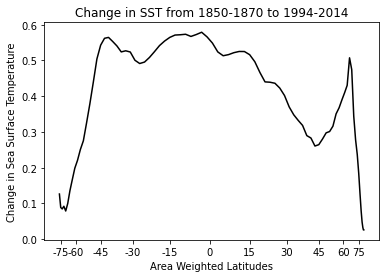

In [96]:
deltasst = histsst_hist - histsst_control

xlabels=np.arange(-75,90,15)

def AreaWeightPlt(y,lat,xlabels,color):
    '''
    Area weighted latitude plotting
    
    y - y axis variable
    lat - variable.lat
    xlabels - already defined arange of values from -75 to 75
    '''
    x=np.sin(lat/360*2*np.pi);
    plt.plot(x,y,color=color)
    plt.xticks(np.sin(xlabels*2*np.pi/360),xlabels)

AreaWeightPlt(deltasst,histsst.lat,xlabels,'black')
plt.xlabel('Area Weighted Latitudes')
plt.ylabel('Change in Sea Surface Temperature')
plt.title('Change in SST from 1850-1870 to 1994-2014')

## Bring in aquaplanet control SST

In [100]:
# Control SST
lats = np.linspace(-np.pi/2, np.pi/2, 50)
SST = np.zeros(50)
i = 0
for lat in lats:
    if lat < -np.pi/3:
        SST[i] = 0
    elif lat > np.pi/3:
        SST[i] = 0
    else:
        SST[i] = 27 * (1 - np.sin(3*lat/2)**2)
    i += 1
print(SST)

lats_degrees = lats * 180/np.pi
print(lats_degrees)

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.17304592  0.8306763   1.9555727
  3.50624704  5.42550784  7.64256952 10.07566312 12.63505203 15.22634168
 17.75396094 20.12468695 22.25108334 24.05472501 25.46909064 26.44201602
 26.93761802 26.93761802 26.44201602 25.46909064 24.05472501 22.25108334
 20.12468695 17.75396094 15.22634168 12.63505203 10.07566312  7.64256952
  5.42550784  3.50624704  1.9555727   0.8306763   0.17304592  0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
[-90.         -86.32653061 -82.65306122 -78.97959184 -75.30612245
 -71.63265306 -67.95918367 -64.28571429 -60.6122449  -56.93877551
 -53.26530612 -49.59183673 -45.91836735 -42.24489796 -38.57142857
 -34.89795918 -31.2244898  -27.55102041 -23.87755102 -20.20408163
 -16.53061224 -12.85714286  -9.18367347  -5.51020408  -1.83673469
   1.83673469   5.51020408   9.18367347  12.85714286  16.53061224
  20.20408163  23.8

In [102]:
# Making control into an array

sim_control = xr.Dataset(data_vars=dict(surface_temp=(["lat"],SST)), coords=dict(lat=(["lat"],lats_degrees)))
sim_control

<xarray.Dataset>
Dimensions:       (lat: 50)
Coordinates:
  * lat           (lat) float64 -90.0 -86.33 -82.65 -78.98 ... 82.65 86.33 90.0
Data variables:
    surface_temp  (lat) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [103]:
# Reinterpolating

sim_control = sim_control.interp(lat=new_lats)
sim_control

<xarray.Dataset>
Dimensions:       (lat: 88)
Coordinates:
  * lat           (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 77 79 81 83 85 87
Data variables:
    surface_temp  (lat) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

Text(0, 0.5, 'SST (K)')

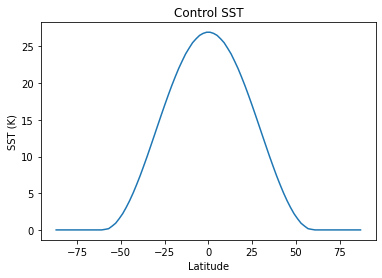

In [111]:
plt.plot(sim_control.lat, sim_control.surface_temp)
plt.title('Control SST')
plt.xlabel('Latitude')
plt.ylabel('SST (K)')

Text(0, 0.5, 'SST (K)')

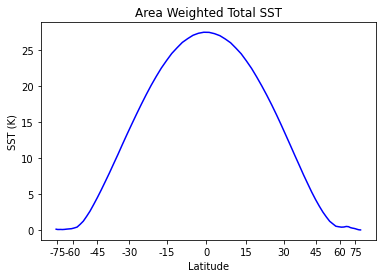

In [112]:
# Adding the change in SST to our control SST....

total_sst = sim_control.surface_temp + deltasst

def AreaWeightPlt(y,lat,xlabels,color):
    '''
    Area weighted latitude plotting
    
    y - y axis variable
    lat - variable.lat
    xlabels - already defined arange of values from -75 to 75
    '''
    x=np.sin(lat/360*2*np.pi);
    plt.plot(x,y,color=color)
    plt.xticks(np.sin(xlabels*2*np.pi/360),xlabels)

AreaWeightPlt(total_sst,histsst.lat,xlabels,'blue')
plt.title('Area Weighted Total SST')
plt.xlabel('Latitude')
plt.ylabel('SST (K)')

Text(0, 0.5, 'SST (K)')

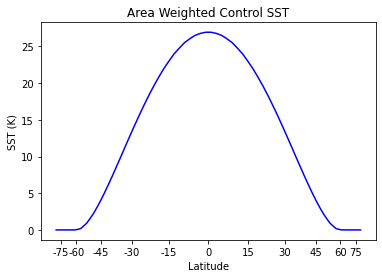

In [113]:
AreaWeightPlt(sim_control.surface_temp,histsst.lat,xlabels,'blue')
plt.title('Area Weighted Control SST')
plt.xlabel('Latitude')
plt.ylabel('SST (K)')

Text(0, 0.5, 'SST (K)')

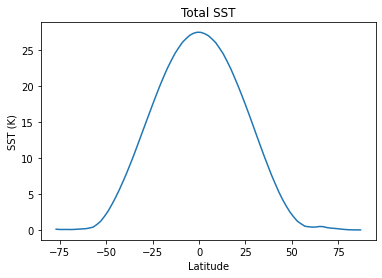

In [114]:
total_sst.plot()
plt.title('Total SST')
plt.xlabel('Latitude')
plt.ylabel('SST (K)')